In [2]:
%%capture --no-stderr
%pip install -U langchain tavily-python langgraph matplotlib langchain_community langchain-openai scikit-learn langchainhub langchain-ollama nomic[local]
%pip install -U langchain-nomic
%pip install beautifulsoup4
%pip install beautifulsoup4 requests


In [8]:
import os
os.environ["OPENAI_API_KEY"] = ''
os.environ["LANGCHAIN_API_KEY"] = ''
os.environ["TAVILY_API_KEY"] = ''
os.environ["FIREWORKS_API_KEY"] = ''
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "Videogame-classification-agent"

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
# from langchain_openai import OpenAIEmbeddings
from langchain_ollama import OllamaEmbeddings
from langchain_core.tools import tool

# List of URLs to load documents from
urls = [
    "https://www.hp.com/us-en/shop/tech-takes/video-game-genres",
    "https://codakid.com/video-game-genres/",
    "https://voice123.com/blog/video-games/video-game-genres/",
    "https://www.uswitch.com/broadband/guides/video-game-genres/",
    "https://vsrecommendedgames.fandom.com/wiki/A_List_and_Guide_to_Game_Genres",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using NomicEmbeddings
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
    #embedding=OllamaEmbeddings(model='nomic-embed-text'),
    # embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever(k=4)

Downloading: 100%|██████████| 274M/274M [00:25<00:00, 10.7MiB/s] 
Verifying: 100%|██████████| 274M/274M [00:00<00:00, 524MiB/s] 


In [12]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [15]:
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

llm = ChatOllama(
    model="llama3.1",
    temperature=0,
)

rag_chain = prompt | llm | StrOutputParser()

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

# JSON
llm = ChatOllama(model="llama3.1", 
                 format="json", 
                 temperature=0)


prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()

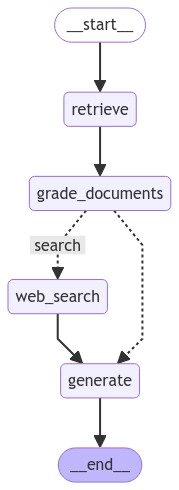

In [21]:
from typing_extensions import TypedDict, List
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [22]:
import uuid 

def predict_custom_agent_answer(example: dict):
    
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}

example = {"input": "What are the types of video game genres?"}
response = predict_custom_agent_answer(example)
response

{'response': 'There are several types of video game genres, including:\n\n* Action: requires quick reflexes and intense action with combat or fighting.\n* Adventure: features players exploring exciting worlds and environments.\n* Role-Playing Games (RPG): involves playing as a character that gains strength and experience through challenges and levels.\n\nThese genres can have sub-genres and hybrids, such as first-person shooter games within the action genre.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'generate_answer']}

In [19]:
example2 = {"input": "What is the most played type of genre?"}
response = predict_custom_agent_answer(example2)
response

{'response': "The most played type of genre is Shooter games, according to Statista's report on the most popular video game genres worldwide in 2022. This genre was most-played across almost all age groups, including those aged 16-64 years. It is also mentioned as a top-selling genre in various reports and articles.",
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

In [20]:
example3 = {"input": "How many types of video game genres are there today?"}
response = predict_custom_agent_answer(example3)
response

{'response': 'There are 10 main video game genres, each with multiple subgenres and hybrids. The top 3 game genres are action, adventure, and RPG (role-play games). These genres have various subcategories and overlap with other types of games.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'generate_answer']}

In [21]:
example4 = {"input": "What are the least played types of genres?"}
response = predict_custom_agent_answer(example4)
response

{'response': "Unfortunately, I don't know the answer to your question about the least played types of genres. The provided documents mention various music and video game genres, but they do not provide information on the least popular ones.",
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

In [23]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    (
        "What are the types of video game genres?",
        "The types of video game genres include:\n\n* Action Games (e.g., shooters, fighting games)\n* Adventure Games (e.g., graphic adventures, text adventures)\n* Role-Playing Games (RPGs) (e.g., action RPGs, MMORPGs)\n* Simulation Games (e.g., construction and management simulation, life simulation)\n* Strategy Games (e.g., 4X, real-time strategy, turn-based strategy)\n* Sports Games\n* Puzzle Games\n* Idle Games\n\nThese genres can further sub-divide into more specific categories.",
    ),
    (
        "What is the most played type of genre?",
        "The most played type of genre is Shooter games, according to Statista's report on the most popular video game genres worldwide in 2022. This genre was most-played across almost all age groups, including those aged 16-64 years. It is also mentioned as a top-selling genre in various reports and articles.",
    ),
    (
        "How many types of video game genres are there today?",
        "There are 10 main video game genres, each with multiple subgenres and hybrids. The top 3 game genres are action, adventure, and RPG (role-play games). These genres have various subcategories and overlap with other types of games.",
    ),
    (
        "What are the least played types of genres?",
        "Unfortunately, I don't know the answer to your question about the least played types of genres. The provided documents mention various music and video game genres, but they do not provide information on the least popular ones.",
    ),
]

# Save it
dataset_name = "RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

Now, we'll use an `LLM as a grader` to compare both agent responses to our ground truth reference answer.

[Here](https://smith.langchain.com/hub/rlm/rag-answer-vs-reference) is the default prompt that we can use.

We'll use `gpt-4o` as our LLM grader.

In [24]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get the question, the ground truth reference answer, RAG chain answer prediction
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # Define an LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]
    return {"key": "answer_v_reference_score", "score": score}

c:\Users\juan.bernadac\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


### Trajectory

Second, [we can assess the list of tool calls](https://docs.smith.langchain.com/tutorials/Developers/agents#trajectory) that each agent makes relative to expected trajectories.

This evaluates the specific reasoning traces taken by our agents!

In [13]:
from langsmith.schemas import Example, Run

# Reasoning traces that we expect the agents to take
expected_trajectory_1 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "web_search",
    "generate_answer",
]
expected_trajectory_2 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "generate_answer",
]

def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}

In [25]:
from langsmith.evaluation import evaluate

dataset_name = "RAG Agent Testing"
model_tested = "llama3.1"
metadata = "CRAG, llama3.1"
experiment_prefix = f"custom-agent-{model_tested}"
experiment_results = evaluate(
    predict_custom_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator, check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3,
    max_concurrency=1,
    metadata={"version": metadata},
)

NameError: name 'check_trajectory_custom' is not defined

Dataset - 

https://smith.langchain.com/public/6c6c4543-1e56-4126-ab18-a84a31ff4946/d

Results -

* Latency for llama3.1 appears higher than llama3.
* Compares well to other, larger llms and beat llama3.

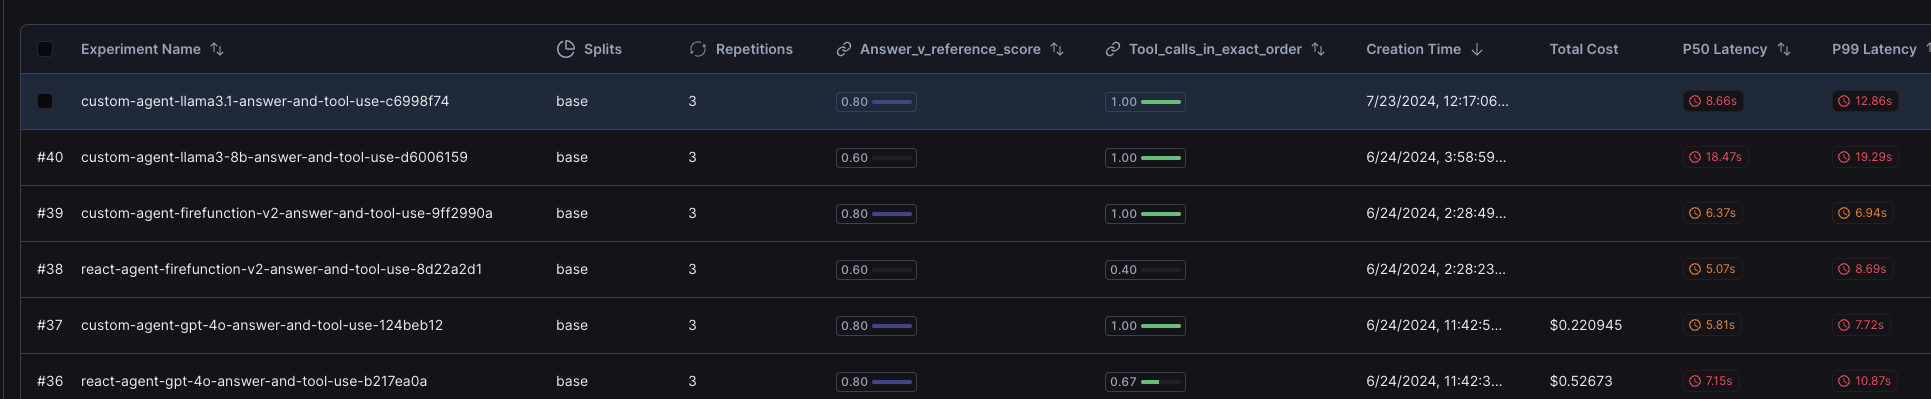